In [1]:
import copy
import os
import pickle
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset

from utils.options import args_parser
from utils.train_utils import get_data, get_model
from models.Update import DatasetSplit
from models.test import test_img_local, test_img_local_all, test_img_global

import pdb
import easydict

import sys

In [2]:
def record_net_data_stats(net_dataidx_map, all_targets):
    net_cls_counts = {}#각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(all_targets[dataidx], return_counts=True)#전체 train data 중에 net_i번째 client가 가지고 있는 data가 어떤 label을 가지고 있는지의 정보가 unq, unq의 각 element가 몇개 들어있는지 기재하는게 unq_count이다!!
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}#tmp에는 unq가 key unq_count가 value가 되게 기재!!
        net_cls_counts[net_i] = tmp
    return net_cls_counts #각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

In [3]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [3]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('body', 'body')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.01,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': False,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                test_dataloader = DataLoader(dataset_test, batch_size=args.bs, shuffle=False)
   

                # build model
                model = get_model(args)
                model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                model.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                
                model.eval()


                # 클래스별로 예측 성공한 데이터와 예측 실패한 데이터의 개수를 저장할 리스트를 생성합니다.
                success_counts = [0 for _ in range(10)]
                failure_counts = [0 for _ in range(10)]

                # 클래스별로 softmax 확률을 누적할 리스트를 생성합니다.
                success_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
                failure_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
                
                # 클래스별로 정확한 예측 수를 저장할 리스트를 생성합니다.
                accuracies = [0 for _ in range(10)]


                # 각 데이터의 예측 결과를 확인하고 클래스별로 softmax 확률을 누적합니다.
                with torch.no_grad():
                    for images, labels in test_dataloader:
                        if args.gpu != -1:
                            images, labels = images.to(args.device), labels.to(args.device)

                        outputs = model(images)
                        softmax_probs = torch.nn.functional.softmax(outputs, dim=1)

                        predicted_labels = torch.argmax(softmax_probs, dim=1)

                        for i in range(len(labels)):
                            label = labels[i].item()
                            predicted_label = predicted_labels[i].item()
                            prob_vector = softmax_probs[i]

                            if predicted_label == label:
                                # 예측 성공한 경우
                                success_counts[label] += 1
                                success_prob_sums[label] += prob_vector
                                accuracies[label] += 1
                            else:
                                # 예측 실패한 경우
                                failure_counts[label] += 1
                                failure_prob_sums[label] += prob_vector
                                

            # 클래스별로 평균 softmax 확률 벡터를 계산합니다.
            success_prob_vectors = [success_prob_sums[i] / success_counts[i] for i in range(10)]
            failure_prob_vectors = [failure_prob_sums[i] / failure_counts[i] for i in range(10)]
            classwise_accuracy=[]

            # 결과 출력
            for i in range(10):
                print(f"Class {i+1} - Accuracy: {success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
                classwise_accuracy.append(success_counts[i]/(success_counts[i]+failure_counts[i]))
                print("Success Probability Vector:")
                print(success_prob_vectors[i])
            
            # 결과 출력
            for i in range(10):
                print(f"Class {i+1} - Accuracy: {1-success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
                
                print("Failure Probability Vector:")
                print(failure_prob_vectors[i])
            print(sum(classwise_accuracy) / len(classwise_accuracy))

Files already downloaded and verified
Files already downloaded and verified
Class 1 - Accuracy: 84.10%
Success Probability Vector:
tensor([9.4426e-01, 4.4952e-03, 1.3391e-02, 4.6167e-03, 3.9284e-03, 4.2680e-04,
        1.3283e-04, 3.8050e-03, 1.8196e-02, 6.7463e-03], device='cuda:0')
Class 2 - Accuracy: 89.10%
Success Probability Vector:
tensor([5.3594e-03, 9.6156e-01, 1.4501e-04, 5.4893e-04, 5.9225e-05, 2.8821e-04,
        1.6698e-03, 6.6076e-04, 4.0171e-03, 2.5695e-02], device='cuda:0')
Class 3 - Accuracy: 62.50%
Success Probability Vector:
tensor([0.0250, 0.0013, 0.8602, 0.0220, 0.0408, 0.0163, 0.0222, 0.0065, 0.0045,
        0.0012], device='cuda:0')
Class 4 - Accuracy: 61.40%
Success Probability Vector:
tensor([0.0076, 0.0035, 0.0138, 0.8013, 0.0194, 0.1073, 0.0284, 0.0080, 0.0069,
        0.0038], device='cuda:0')
Class 5 - Accuracy: 81.00%
Success Probability Vector:
tensor([4.8914e-03, 4.7568e-04, 2.3463e-02, 1.2083e-02, 9.1089e-01, 1.0331e-02,
        1.4601e-02, 2.2486e-02, 5

In [4]:
test_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=False)

# Initialize variables to store results
successful_norms = [[] for _ in range(10)]  # List to store successful data feature vector norms for each class
failed_norms = [[] for _ in range(10)]  # List to store failed data feature vector norms for each class

# Iterate over the test dataset and collect feature vector norms
for images, labels in test_dataloader:
    images = images.to(args.device)
    labels = labels.to(args.device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    norm = torch.norm(model.extract_features(images), dim=1).item()
    class_index = labels.item()

    if predicted == labels:  # Successful prediction
        successful_norms[class_index].append(norm)
    else:  # Failed prediction
        failed_norms[class_index].append(norm)

# Compute mean and variance of feature vector norms for each class
successful_means = [torch.tensor(norms).mean().item() for norms in successful_norms]
successful_variances = [torch.tensor(norms).var().item() for norms in successful_norms]

successful_min = [torch.tensor(norms).min().item() for norms in successful_norms]
successful_max = [torch.tensor(norms).max().item() for norms in successful_norms]

failed_means = [torch.tensor(norms).mean().item() for norms in failed_norms]
failed_variances = [torch.tensor(norms).var().item() for norms in failed_norms]
failed_min = [torch.tensor(norms).min().item() for norms in failed_norms]
failed_max = [torch.tensor(norms).max().item() for norms in failed_norms]

# Print the results
for class_index in range(10):
    print(f"Class {class_index + 1} (Successful): Mean = {successful_means[class_index]}, Variance = {successful_variances[class_index]}, Min = {successful_min[class_index]}, Max = {successful_max[class_index]}")
    print(f"Class {class_index + 1} (Failed): Mean = {failed_means[class_index]}, Variance = {failed_variances[class_index]}, Min = {failed_min[class_index]}, Max = {failed_max[class_index]}")

Class 1 (Successful): Mean = 154.2257537841797, Variance = 255.85089111328125, Min = 120.08184814453125, Max = 229.54261779785156
Class 1 (Failed): Mean = 157.54571533203125, Variance = 309.2654724121094, Min = 115.00395202636719, Max = 204.96778869628906
Class 2 (Successful): Mean = 164.5302734375, Variance = 370.97430419921875, Min = 122.11808776855469, Max = 261.310302734375
Class 2 (Failed): Mean = 167.97914123535156, Variance = 378.8348083496094, Min = 128.94480895996094, Max = 241.0978240966797
Class 3 (Successful): Mean = 165.8637237548828, Variance = 246.12518310546875, Min = 127.2803955078125, Max = 243.36705017089844
Class 3 (Failed): Mean = 163.50511169433594, Variance = 305.5484313964844, Min = 123.05377960205078, Max = 228.81715393066406
Class 4 (Successful): Mean = 163.92776489257812, Variance = 232.66407775878906, Min = 130.04701232910156, Max = 249.32498168945312
Class 4 (Failed): Mean = 165.02175903320312, Variance = 263.4648742675781, Min = 131.1959991455078, Max = 23

# Get a feature centroid vector and each vector's norm and cosine similarity each other (Test Data)

In [5]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [3]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('body', 'body')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.01,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': False,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                dict_save_path = 'dict_users_10_{}.pkl'.format(args.shard_per_user)
                with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                    dict_users_train, dict_users_test = pickle.load(handle)
    

                # build model
                net_glob = get_model(args)
                net_glob.train()
                

                net_local_list = []
                for user_ix in range(args.num_users):
                    net_local_list.append(copy.deepcopy(net_glob))

                criterion = nn.CrossEntropyLoss()

                before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
                after_acc_results = []
                
                for user, net_local in enumerate(net_local_list):
                    model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                    net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    before_acc_results.append(acc_test)
                    
                print(before_acc_results)

                print ("Before min/max/mean/std of accuracy")
                print (np.min(before_acc_results), np.max(before_acc_results), np.mean(before_acc_results), round(np.std(before_acc_results), 2))
                    
                    
                    


Files already downloaded and verified
Files already downloaded and verified
[59.0, 78.0, 78.21782178217822, 88.88888888888889, 78.0, 77.22772277227723, 77.22772277227723, 76.0, 72.72727272727273, 81.18811881188118, 77.0, 82.0, 84.15841584158416, 77.0, 87.0, 82.0, 76.0, 82.82828282828282, 74.0, 83.83838383838383, 83.0, 81.0, 80.1980198019802, 62.0, 84.84848484848484, 87.12871287128714, 77.77777777777777, 83.33333333333333, 78.0, 83.33333333333333, 91.91919191919192, 78.0, 71.0, 80.0, 77.0, 83.0, 77.0, 67.0, 67.67676767676768, 76.23762376237623, 81.18811881188118, 73.0, 78.0, 67.32673267326733, 80.3921568627451, 79.79797979797979, 64.64646464646465, 70.70707070707071, 71.0, 82.82828282828282, 82.82828282828282, 82.82828282828282, 76.0, 80.8080808080808, 65.0, 81.0, 75.0, 80.8080808080808, 62.37623762376238, 90.9090909090909, 81.18811881188118, 76.0, 77.0, 74.74747474747475, 83.83838383838383, 86.0, 77.22772277227723, 72.72727272727273, 74.74747474747475, 87.0, 83.0, 81.0, 85.294117647058

In [6]:
    print(">>> Distributing client train data...")
    traindata_cls_dict = record_net_data_stats(dict_users_train, np.array(dataset_train.targets))
    print('Data statistics: %s' % str(traindata_cls_dict))

>>> Distributing client train data...
Data statistics: {0: {3: 166, 4: 167, 9: 167}, 1: {1: 167, 3: 167, 4: 166}, 2: {3: 167, 6: 167, 7: 166}, 3: {1: 167, 8: 166, 9: 167}, 4: {0: 167, 2: 167, 8: 167}, 5: {1: 167, 3: 167, 7: 167}, 6: {2: 166, 8: 167, 9: 167}, 7: {0: 167, 3: 167, 7: 167}, 8: {2: 166, 6: 167, 9: 166}, 9: {4: 167, 6: 166, 9: 167}, 10: {3: 167, 4: 167, 8: 166}, 11: {7: 333, 8: 167}, 12: {5: 166, 6: 334}, 13: {0: 167, 2: 167, 3: 166}, 14: {0: 167, 1: 334}, 15: {2: 166, 8: 167, 9: 166}, 16: {0: 167, 3: 167, 4: 167}, 17: {1: 333, 2: 167}, 18: {1: 167, 2: 166, 8: 167}, 19: {1: 167, 3: 167, 5: 167}, 20: {4: 167, 5: 166, 9: 166}, 21: {4: 166, 6: 334}, 22: {1: 167, 2: 167, 7: 167}, 23: {3: 167, 5: 334}, 24: {0: 166, 2: 167, 8: 167}, 25: {0: 333, 8: 167}, 26: {5: 167, 6: 167, 9: 167}, 27: {0: 167, 6: 167, 7: 167}, 28: {0: 166, 5: 167, 9: 166}, 29: {0: 166, 7: 167, 9: 166}, 30: {0: 167, 1: 332}, 31: {5: 167, 9: 334}, 32: {2: 167, 7: 332}, 33: {2: 167, 6: 167, 9: 166}, 34: {0: 167, 3

In [7]:
    print(">>> Distributing client test data...")
    testdata_cls_dict = record_net_data_stats(dict_users_test, np.array(dataset_test.targets))
    print('Data statistics: %s' % str(testdata_cls_dict))

>>> Distributing client test data...
Data statistics: {0: {3: 33, 4: 33, 9: 34}, 1: {1: 33, 3: 34, 4: 33}, 2: {3: 34, 6: 34, 7: 33}, 3: {1: 33, 8: 33, 9: 33}, 4: {0: 33, 2: 34, 8: 33}, 5: {1: 34, 3: 34, 7: 33}, 6: {2: 34, 8: 33, 9: 34}, 7: {0: 33, 3: 34, 7: 33}, 8: {2: 33, 6: 33, 9: 33}, 9: {4: 34, 6: 33, 9: 34}, 10: {3: 34, 4: 33, 8: 33}, 11: {7: 66, 8: 34}, 12: {5: 34, 6: 67}, 13: {0: 34, 2: 33, 3: 33}, 14: {0: 33, 1: 67}, 15: {2: 33, 8: 34, 9: 33}, 16: {0: 34, 3: 33, 4: 33}, 17: {1: 66, 2: 33}, 18: {1: 33, 2: 33, 8: 34}, 19: {1: 33, 3: 33, 5: 33}, 20: {4: 33, 5: 33, 9: 34}, 21: {4: 33, 6: 67}, 22: {1: 34, 2: 34, 7: 33}, 23: {3: 33, 5: 67}, 24: {0: 33, 2: 33, 8: 33}, 25: {0: 67, 8: 34}, 26: {5: 33, 6: 33, 9: 33}, 27: {0: 34, 6: 34, 7: 34}, 28: {0: 33, 5: 34, 9: 33}, 29: {0: 34, 7: 34, 9: 34}, 30: {0: 33, 1: 66}, 31: {5: 33, 9: 67}, 32: {2: 33, 7: 67}, 33: {2: 34, 6: 33, 9: 33}, 34: {0: 33, 3: 33, 8: 34}, 35: {6: 67, 7: 33}, 36: {2: 33, 6: 34, 7: 33}, 37: {0: 34, 3: 33, 5: 33}, 38: {2

In [8]:
    head_params = [p for name, p in net_local_list[0].named_parameters() if 'classifier' in name]

    #Get the innerproduct of the classifier part

    print(head_params[0].shape)

    print(head_params[1].shape)
    print(head_params[1])


    # Get the inner product result of the classifier
    print("Weight norm square of each class part of classifier")
    print(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1))))


    # Get the cosine similarity result of the classifier
    print("Cosine similarity of each class part of classifier")

    normalized_classifier=nn.functional.normalize(head_params[0], p=2, dim=1)
    print(torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)))

torch.Size([10, 512])
torch.Size([10])
Parameter containing:
tensor([-0.0319,  0.0383,  0.0208, -0.0020, -0.0234,  0.0149,  0.0372, -0.0413,
        -0.0151,  0.0232], device='cuda:0', requires_grad=True)
Weight norm square of each class part of classifier
tensor([0.3233, 0.3360, 0.3247, 0.3356, 0.3469, 0.3316, 0.3183, 0.3414, 0.3340,
        0.3452], device='cuda:0', grad_fn=<DiagonalBackward0>)
Cosine similarity of each class part of classifier
tensor([[ 1.0000e+00, -7.6741e-02,  3.0262e-02,  1.5851e-02,  1.0705e-01,
         -2.0421e-02, -3.1438e-02,  3.2524e-02, -2.0170e-02,  4.7581e-02],
        [-7.6741e-02,  1.0000e+00, -1.4284e-02, -3.0395e-02,  2.9169e-02,
          6.5581e-02, -2.9996e-02, -1.2811e-02, -2.1647e-02, -1.4465e-02],
        [ 3.0262e-02, -1.4284e-02,  1.0000e+00,  4.6461e-02,  5.4965e-03,
          1.8842e-02,  1.0453e-03,  1.1918e-02,  4.4771e-03, -1.5096e-02],
        [ 1.5851e-02, -3.0395e-02,  4.6461e-02,  1.0000e+00, -7.6464e-03,
         -1.2543e-02,  2.240

Weight norm of each class part of classifier
tensor([0.5686, 0.5797, 0.5698, 0.5793, 0.5889, 0.5758, 0.5642, 0.5843, 0.5779,
        0.5875], device='cuda:0', grad_fn=<SqrtBackward0>)


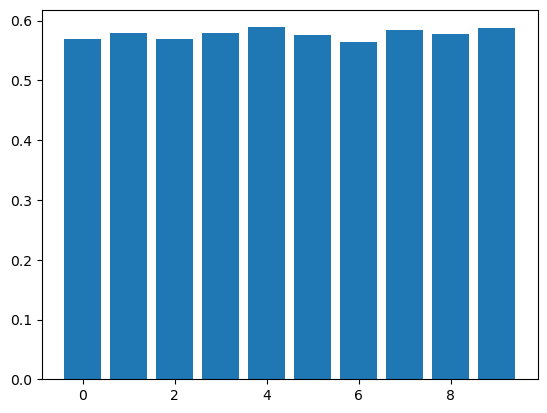

In [9]:
import matplotlib.pyplot as plt

print("Weight norm of each class part of classifier")
print(torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))).cpu().detach().numpy())

plt.show()

# HeatMap of weight bias

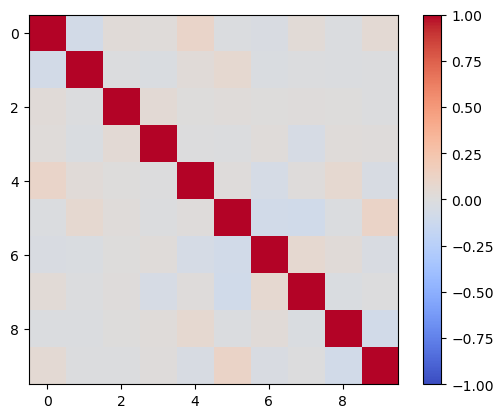

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)).cpu().detach().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [11]:
                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]
                
                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]


                #Get a inner product of centroids

                cos_sim_hist={}

                with torch.no_grad():
                    inner_product_hist={key: 0 for key in class_mean_dict.keys()}
                    for images, labels in ldr_test:
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)
                        for i in range(len(label)):

                            mean_feature=class_mean_dict[label[i]]

                            normalized_mean_feature=mean_feature/torch.norm(mean_feature)

                            class_mask = labels == label[i]  # "cat" 클래스의 마스크를 생성합니다.

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 평균 벡터를 계산합니다.
                                class_features = features[class_mask]
                                normalized_class_features=nn.functional.normalize(class_features, p=2, dim=1)

                                inner_product=torch.mm(normalized_class_features, normalized_mean_feature.unsqueeze(1))
                                if label[i] not in cos_sim_hist.keys():
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.array([inner_product.squeeze().cpu().numpy()[()]])
                                    else:
                                        cos_sim_hist[label[i]]=inner_product.squeeze().cpu().numpy()
                                else:
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], np.array([inner_product.squeeze().cpu().numpy()[()]])), axis=0)

                                    else:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], inner_product.squeeze().cpu().numpy()), axis=0)

                                        
                cos_sim_mean={}
                cos_sim_var={}

                for key in class_sums.keys():
                    if key in class_counts:
                        cos_sim_mean[key] = cos_sim_hist[key].mean()
                        cos_sim_var[key] = cos_sim_hist[key].var()
                print("-------------------MEAN-------------------")                

                print(cos_sim_mean)
                print("-------------------VAR-------------------")                

                print(cos_sim_var)



-------------------MEAN-------------------
{0: 0.9877799, 1: 0.9854551, 2: 0.99094856, 3: 0.99301094, 4: 0.9893941, 5: 0.9922434, 6: 0.99042785, 7: 0.98926365, 8: 0.9859082, 9: 0.99015343}
-------------------VAR-------------------
{0: 0.000101240985, 1: 0.00018773561, 2: 7.0004935e-05, 3: 4.4415334e-05, 4: 9.015936e-05, 5: 4.8605816e-05, 6: 6.351328e-05, 7: 8.152036e-05, 8: 0.00015609067, 9: 9.402357e-05}


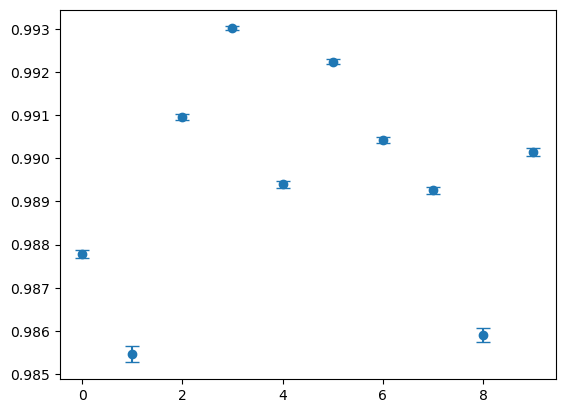

In [12]:
import matplotlib.pyplot as plt


class_index=[i for i in range(num_classes)]

#centroid로부터 cosine similarity 값들의 mean, variance
classwise_mean=list(cos_sim_mean.values())
classwise_var=list(cos_sim_var.values())

plt.errorbar(class_index, classwise_mean, classwise_var, fmt='o', capsize=5)

plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [13]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [3]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('body', 'body')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.01,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': False,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                dict_save_path = 'dict_users_10_{}.pkl'.format(args.shard_per_user)
                with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                    dict_users_train, dict_users_test = pickle.load(handle)
    

                # build model
                net_glob = get_model(args)
                net_glob.train()
                

                net_local_list = []
                for user_ix in range(args.num_users):
                    net_local_list.append(copy.deepcopy(net_glob))

                criterion = nn.CrossEntropyLoss()

                before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
                after_acc_results = []
                
                for user, net_local in enumerate(net_local_list):
                    model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                    net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    before_acc_results.append(acc_test)

                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]                    


                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]

                print(class_mean_dict)
                #Get a Inner product of each class's centroid vector

                sorted_keys=sorted(class_mean_dict)
                print(sorted_keys)

                class_mean_lst=[]


                for key in sorted_keys:
                    class_mean_lst.append(class_mean_dict[key])

                class_mean_lst=torch.stack(class_mean_lst)


                print(class_mean_lst.shape)
                print(class_mean_lst.transpose(0,1).shape)

                #Get the each centroid vector's norm
                print("-------------Norm of each centroid vectors --------------")
                print(torch.diagonal(torch.mm(class_mean_lst, class_mean_lst.transpose(0,1))))


                #Get the cosine similarity result between eacn centroid vectors


                normalized_class_mean_lst=nn.functional.normalize(class_mean_lst, p=2, dim=1)
                print("-------------Cosine similarity of Each Centroid vectors--------------")
                print(torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy())
                    
                    
    


Files already downloaded and verified
Files already downloaded and verified
{0: tensor([6.8163e+00, 8.6179e+00, 1.0855e+01, 3.8022e+00, 5.3432e+00, 7.1733e+00,
        9.4809e+00, 8.0135e+00, 1.0020e-04, 0.0000e+00, 0.0000e+00, 5.4642e+00,
        1.3624e+01, 7.6666e+00, 0.0000e+00, 1.0700e+01, 4.8030e+00, 2.7298e+00,
        0.0000e+00, 8.5348e+00, 0.0000e+00, 7.6671e+00, 5.8987e+00, 9.4083e+00,
        8.9097e+00, 2.7533e+00, 5.9874e+00, 2.4195e+00, 4.5012e+00, 0.0000e+00,
        0.0000e+00, 1.2390e-02, 1.1335e+01, 7.6435e+00, 7.9524e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0810e+01, 8.0461e+00, 0.0000e+00,
        0.0000e+00, 6.1654e+00, 0.0000e+00, 1.1433e+01, 2.3273e+00, 5.5686e+00,
        0.0000e+00, 6.2756e+00, 0.0000e+00, 6.3178e+00, 1.0440e+01, 9.2772e+00,
        9.5763e+00, 0.0000e+00, 3.6022e+00, 1.1620e+01, 7.2144e+00, 8.5440e+00,
        0.0000e+00, 7.2345e+00, 0.0000e+00, 3.8218e+00, 5.8962e+00, 3.4900e+00,
        1.0048e+01, 0.0000e+00, 3.1253e+

# Cosine Similarity of Centroid Vectors

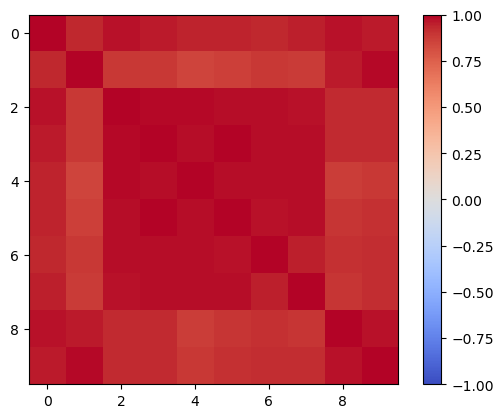

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [15]:
print(type(cos_sim_np))

print(cos_sim_np)

print(cos_sim_np.sum(axis=1))

print(cos_sim_np.sum(axis=0))

<class 'numpy.ndarray'>
[[1.         0.9327537  0.9740629  0.9577737  0.9388838  0.9418117
  0.9352678  0.9465044  0.96912086 0.957248  ]
 [0.9327537  0.9999999  0.8877279  0.8878036  0.84405464 0.86001456
  0.8883982  0.8751773  0.9569568  0.9870007 ]
 [0.9740629  0.8877279  0.9999999  0.9901801  0.98687005 0.98324966
  0.98171794 0.97228086 0.9282702  0.92516255]
 [0.9577737  0.8878036  0.9901801  1.         0.983239   0.9963294
  0.9833607  0.9781747  0.9232632  0.9293495 ]
 [0.9388838  0.84405464 0.98687005 0.983239   0.99999994 0.9836135
  0.97823423 0.9803482  0.8740795  0.8882313 ]
 [0.9418117  0.86001456 0.98324966 0.9963294  0.9836135  1.
  0.9717666  0.9842726  0.8980493  0.9080599 ]
 [0.9352678  0.8883982  0.98171794 0.9833607  0.97823423 0.9717666
  1.         0.950441   0.909359   0.921054  ]
 [0.9465044  0.8751773  0.97228086 0.9781747  0.9803482  0.9842726
  0.950441   1.         0.8932011  0.92041314]
 [0.96912086 0.9569568  0.9282702  0.9232632  0.8740795  0.8980493
  

# Centroid-Feature Alignment

In [16]:
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

tensor([0.1202, 0.1759, 0.0729, 0.0626, 0.1082, 0.0855, 0.1133, 0.1140, 0.1645,
        0.1250], device='cuda:0', grad_fn=<DiagonalBackward0>)


Centroid-Feature Alignment of each class
tensor([0.1202, 0.1759, 0.0729, 0.0626, 0.1082, 0.0855, 0.1133, 0.1140, 0.1645,
        0.1250], device='cuda:0', grad_fn=<DiagonalBackward0>)


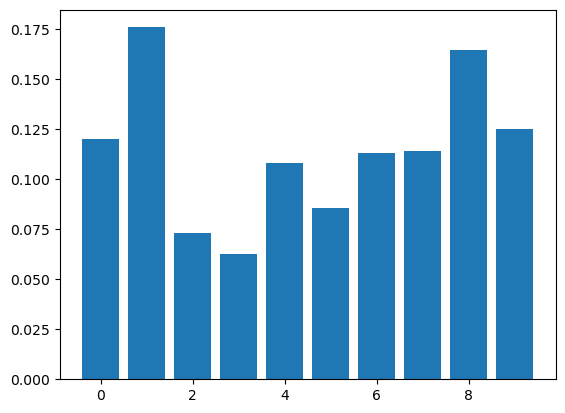

In [17]:
import matplotlib.pyplot as plt

print("Centroid-Feature Alignment of each class")
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))).cpu().detach().numpy())

plt.show()